In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
path='./MNIST_data'

mnist_data = datasets.MNIST(path, download=True, transform=transforms.ToTensor()).train_data.float()
train_mean = mnist_data.mean() / 255
train_std = mnist_data.std() / 255

mnist_sigm = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((train_mean,), (train_std,)),
                lambda x: x.to(device)
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_sigm)

In [5]:
train_data = datasets.MNIST('./MNIST_data', download=True, transform=mnist_sigm)
im = [train_data[i][0] for i in range(len(mnist_data))]
trdata = torch.stack(im).float()
print ("Transformed data mean: {:.8}".format(trdata.mean()))
print ("Transformed data std: {:.8}".format(trdata.std()))

Transformed data mean: -1.9292506e-07
Transformed data std: 1.0


In [6]:
def get_random_h():
    z = torch.randn((50, 10))     
    return z

In [7]:
train_epoch = 300
batch_size = 50
batch_zeros = torch.zeros((batch_size, 1)).to(device)
batch_ones = torch.ones((batch_size, 1)).to(device)

In [8]:
fixed_data, _ = next(iter(test_loader))
fixed_data = fixed_data.to(device)
fixed_h = get_random_h().to(device)

In [9]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), stride=1, device='cpu'):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [10]:
class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.LeakyReLU(0.1), output_padding=0, device='cpu'):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
        self.to(device)
    
    def forward(self, x):
        return self.model(x)

In [11]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Sigmoid(), flatten=False, last_fn=None, device='cpu'):
        super(FullyConnected, self).__init__()
        layers = []
        self.flatten = flatten
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout(dropout))
            layers.append(activation_fn) # нам не нужен дропаут и фнкция активации в последнем слое
        else: 
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        if last_fn is not None:
            layers.append(last_fn)
        self.model = nn.Sequential(*layers)
        self.to(device)
        
    def forward(self, x):
        if self.flatten:
            x = x.view(x.shape[0], -1)
        return self.model(x)

In [12]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, optim_type='SGD', device='cpu', **optim_params):
        super(Net, self).__init__()
        
        self.latent_size = 10
        
        self._conv1 = ConvLayer([1, 32, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        self._conv2 = ConvLayer([32, 64, 4], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        self._conv3 = ConvLayer([64, 64, 3], padding=0, bn=batchnorm, dropout=dropout, stride=2, pool_layer=None, device=device)
        
        self.latent_fn = nn.Sigmoid()
                    
        self.fce = FullyConnected([64*2*2, self.latent_size])
        self.fcd = FullyConnected([self.latent_size, 64*2*2])
        
        self._deconv1 = DeconvLayer([64, 64, 3], stride=2, padding=0, bn=batchnorm, device=device)
        self._deconv2 = DeconvLayer([64, 32, 4], stride=2, padding=0, bn=batchnorm, output_padding=1, device=device)
        self._deconv3 = DeconvLayer([32, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Sigmoid(), device=device)
    
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
                    
        self.discr = FullyConnected([self.latent_size, 256, 256, 1], dropout=0.3, activation_fn=nn.LeakyReLU(0.2), flatten=True, device=device)       
        self.d_optimizer = optim.Adam(self.discr.parameters(), **optim_params)
        
        self.to(device)
        
       
    def conv(self, x):
        l1 = self._conv1(x)
        l2 = self._conv2(l1)
        l3 = self._conv3(l2)
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]
        flatten = l3.view(-1, 64*2*2)
        h = self.latent_fn(self.fce(flatten))
        return h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 64, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
    
    def discriminator(self, x):        
        x = self.discr(x)       
        return x
                
    def forward(self, x):
        self.h = self.encode(x)
        x = self.decode(self.h)
        return x
    
    def ae_loss(self, data):
                       
        output = self.forward(data)     
        self._reconst_loss = F.mse_loss(output, data) 
        
        encoded = self.encode(data) 
        fake_pred = self.discriminator(encoded) 
        self._discr_loss = 0.1 * F.binary_cross_entropy_with_logits(fake_pred, batch_ones)        
        
        self._ae_loss = self._reconst_loss + self._discr_loss
                        
        return self._ae_loss
    
    def ds_loss(self, data):
                       
        encoded = self.encode(data)           
        fake_pred = self.discriminator(encoded)
        true_pred = self.discriminator(get_random_h().to(device))

        fake_loss = F.binary_cross_entropy_with_logits(fake_pred, batch_zeros)
        true_loss = F.binary_cross_entropy_with_logits(true_pred, batch_ones) 
        self._ds_loss = 0.5*(fake_loss + true_loss)
        
        return self._ds_loss

In [13]:
models = {
    #'Adam Discr+bn': Net(True, False, optim_type='Adam', lr=1e-4, device=device),
    'Adam Discr+dp': Net(False, True, optim_type='Adam', lr=1e-4, device=device),
    'Adam Discr+bn+dp': Net(True, True, optim_type='Adam', lr=1e-4, device=device),
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [14]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        for model in models.values():
            
            # train discriminator
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                     
            ds_loss = model.ds_loss(data)        
            ds_loss.backward()
            model.d_optimizer.step()
                        
            # train AE
            model.optim.zero_grad()
            model.d_optimizer.zero_grad()
                      
            ae_loss = model.ae_loss(data)            
            ae_loss.backward()
            model.optim.step()
                       
            
        if batch_idx % 500 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: AE:{:.4f} D:{:.4f}'.format(k, m._ae_loss.item(), m._ds_loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._ae_loss, models[k]._ds_loss))
        print(line + losses)

In [15]:
def plot_latent(images, shape):
    fig = plt.figure(figsize=shape[::-1], dpi=80)
    for j in range(1, len(images) + 1):
        ax = fig.add_subplot(shape[0], shape[1], j)
        ax.matshow(images[j - 1, 0, :, :], cmap = matplotlib.cm.binary)
        plt.xticks(np.array([]))
        plt.yticks(np.array([]))

    plt.show()
    

In [16]:
def test(models, loader, epoch, period, log=None):
    test_size = len(loader)
    test_rc_loss = {k: 0. for k in models}
    test_ds_loss = {k: 0. for k in models}
    test_discr_loss = {k: 0. for k in models}
    with torch.no_grad():
        for batch_idx, (data, _) in enumerate(train_loader):
            output = {k: m.forward(data) for k, m in models.items()}
            for k, m in models.items():                
                m.ae_loss(data)
                test_rc_loss[k] += m._reconst_loss
                test_discr_loss[k] += m._discr_loss
                test_ds_loss[k] += m.ds_loss(data).item() 
    
    for k in models:
        test_rc_loss[k] /= test_size
        test_discr_loss[k] /= test_size 
        test_ds_loss[k] /= test_size 
    report = 'Test losses: \n' + ''.join(['{}: {:.8f} / {:.8f} / {:.8f} \n'.format(k, test_rc_loss[k], 
                                         test_discr_loss[k], test_ds_loss[k]) 
                                         for k in models])
    if log is not None:
        for k in models:
            log[k].append((test_rc_loss[k], test_discr_loss[k], test_ds_loss[k],))
            if epoch % period == 0:
                with torch.no_grad():
                    print ("Model {}:".format(k))
                    ae_data = models[k].forward(fixed_data).clamp(0, 1).cpu().data.numpy()
                    fixed_gen = models[k].decode(fixed_h).clamp(0, 1).cpu().data.numpy()
                    random_gen = models[k].decode(get_random_h().to(device)).clamp(0, 1).cpu().data.numpy()
                    plot_mnist(ae_data, (5, 10))
                    plot_mnist(fixed_gen, (5, 10)) 
                    plot_mnist(random_gen, (5, 10)) 

                    encoded = model.encode(fixed_data[:10])
                    enc_to_lot = encoded.view(-1, 1, 2, 5).clamp(0, 1).cpu().data.numpy()
                    plot_latent(enc_to_lot, (1, 10))
            
    print(report)

In [ ]:
for epoch in range(1, train_epoch):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, epoch, 20, test_log)

Model Adam Discr+dp:


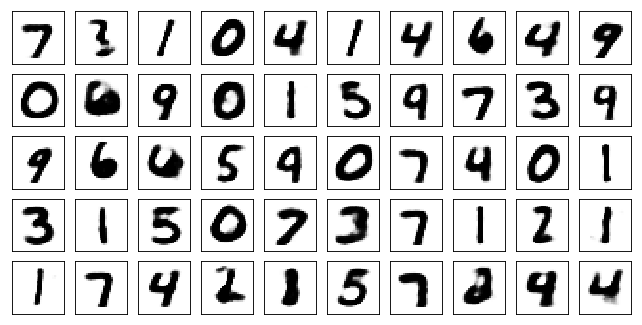

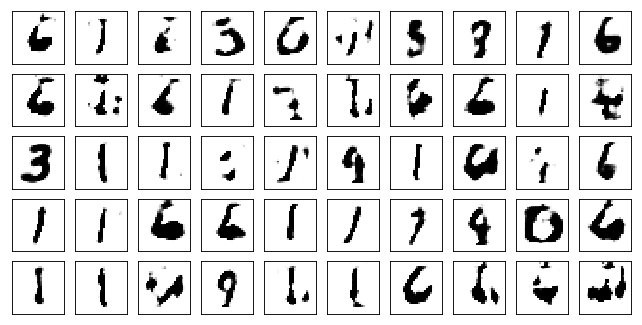

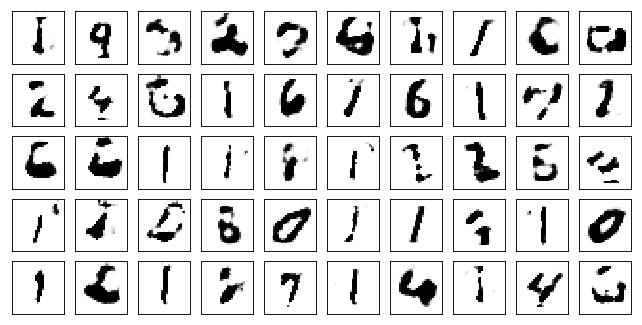

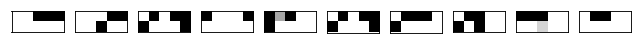

Model Adam Discr+bn+dp:


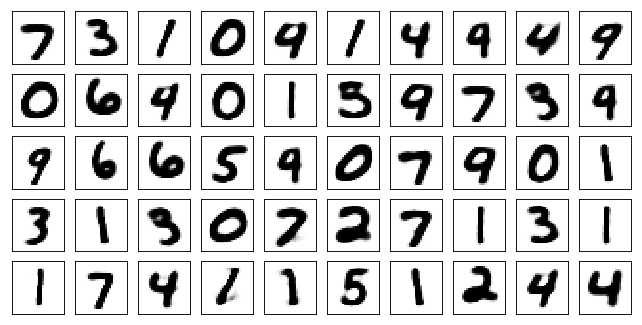

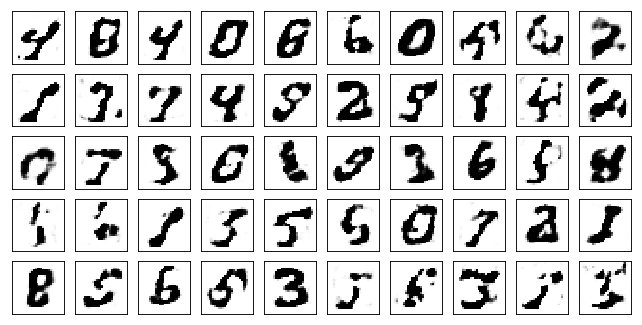

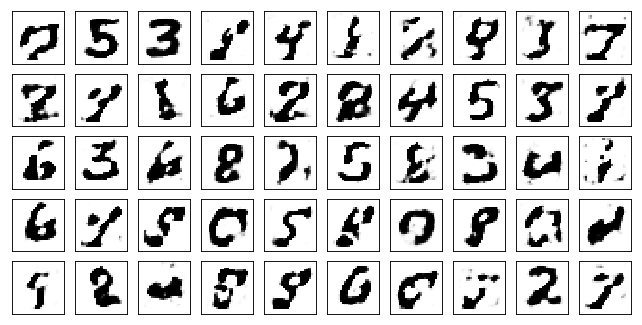

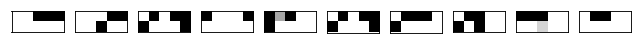

Test losses: 
Adam Discr+dp: 3.11504912 / 5.08126163 / 0.00802497 
Adam Discr+bn+dp: 3.08962131 / 5.47680569 / 0.00118266 



In [18]:
for model in models.values():
    model.eval()
test(models, valid_loader, 1, 1, test_log)

In [20]:
#torch.save(models['Adam Discr+bn'], './adam_ds_bn_l10_1')
torch.save(models['Adam Discr+dp'], './adam_ds_dp_l10_1')
torch.save(models['Adam Discr+bn+dp'], './adam_ds_bndp_l10_1')

/home/aleksey/.conda/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/.conda/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/.conda/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/.conda/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type Deconv

### Вывод результатов

In [21]:
model = torch.load('./adam_ds_bndp_l10_1')

In [22]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).cpu().data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    enc_to_lot = encoded.view(-1, 1, 2, 5).clamp(0, 1).cpu().data.numpy()
    print ('enc=', encoded.shape)


enc= torch.Size([50, 10])


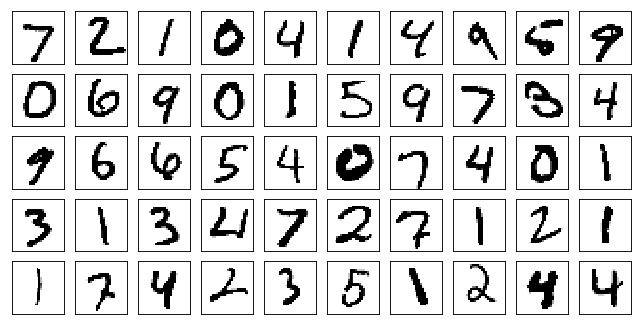

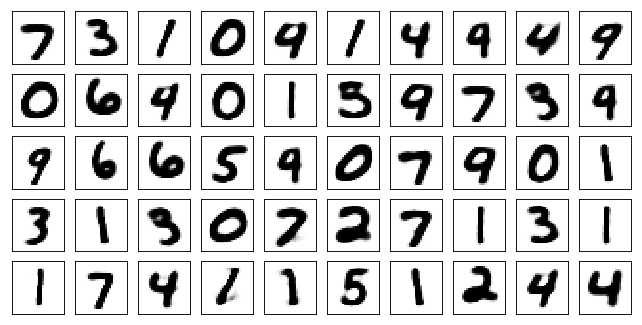

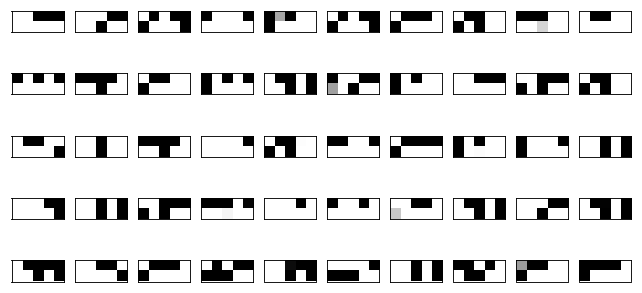

In [23]:
plot_mnist(data.data.clamp(0, 1).cpu().numpy(), (5, 10))
plot_mnist(to_plot, (5, 10))
plot_latent(enc_to_lot, (5, 10))

In [24]:
def show_generated_samples():
    pred_z = torch.randn((50, 10)).to(device)
       
    pred_gen = model.decode(pred_z)
    generated = pred_gen.view(-1, 1, 28, 28).clamp(0, 1).cpu().data.numpy()  
    plot_mnist(generated, (5, 10))

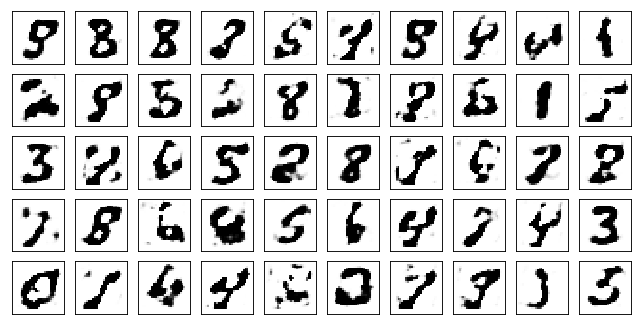

In [25]:
show_generated_samples()